# Load aggregated values per ice shelf
## Making pie-charts and histograms etc

In [1]:
import os
import rioxarray as rioxr
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import glob
import xarray as xr

import rasterio as rio

import pandas as pd 
import seaborn as sns
import dask

# Import user functions
import nbFunctions as myf 


In [2]:
homedir = '/Users/.../'

path2savefig = os.path.join(homedir,'Data/NERD/plots/')
path2iceshelves = os.path.join(homedir,'Data/.../')
path2data = os.path.join(homedir,'Data/NERD/.../')


''' --------------
Get Shapefiles 
------------------ '''
# geojson
gridTiles_geojson_path = os.path.join(homedir,'Data/tiles/gridTiles_iceShelves_EPSG3031.geojson')
gridTiles = gpd.read_file(gridTiles_geojson_path)

# measures ice shelves
iceshelf_path_meas = os.path.join(homedir, 'QGis/Quantarctica/Quantarctica3/Glaciology/MEaSUREs Antarctic Boundaries/IceShelf/IceShelf_Antarctica_v02.shp')
iceshelf_poly_meas = gpd.read_file(iceshelf_path_meas)

## SECTORS for AIS
sector_path = os.path.join(homedir, 'QGis/data_NeRD/plot_insets_AIS_sectors.shp')
sector_poly = gpd.read_file(sector_path)
sector_ID_list = sector_poly['sector_ID'].to_list()


sector_IDs = [id for id in sector_ID_list if '-' not in id]
sector_IDs.sort()
sector_IDs
# sector_ID_list

sector_df = sector_poly.copy()
sector_df = sector_df.drop(sector_df.index[ sector_df['sector_ID'].isin(
                            ['WS-1','WS-2','WIS-1','WIS-2','EIS-1','EIS-2']) ], axis=0)


#### Plot settings

In [4]:
from cycler import cycler

SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18
fs=14
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## Can look for different shades of HEX here: https://www.color-hex.com/color/721f82

## DMG cmap

magma_palette_r = sns.color_palette('magma_r',5) # ['#3b0f70', '#8c2981', '#de4968', '#fe9f6d']
bblue_rgb = (0.6352941176470588, 0.8117647058823529, 0.996078431372549)
magma_palette_r.insert(0,bblue_rgb)
print('magma palette_r : ', magma_palette_r.as_hex()) #[ '#A2CEFE',    '#FFAF78',    '#F1675D',    '#B54279',    '#721F82',    '#2B114F']
# print('temporal_pallete 1997+crest : ', sns.color_palette(my_palette2long).as_hex()) 
display(magma_palette_r)


# cubeH_palette
cubeH_palette = sns.color_palette("cubehelix", 9)#[2:-1]
cubeH_palette

magma palette_r :  ['#a2cffe', '#feb078', '#f1605d', '#b5367a', '#721f81', '#2c115f']


[(0.6352941176470588, 0.8117647058823529, 0.996078431372549),
 (0.997077, 0.690088, 0.471811),
 (0.944006, 0.377643, 0.365136),
 (0.709962, 0.212797, 0.477201),
 (0.445163, 0.122724, 0.506901),
 (0.171713, 0.067305, 0.370771)]

[(0.10120483036935347, 0.08028952282539623, 0.18460915180334375),
 (0.08605633600581405, 0.23824692404212, 0.30561236308077167),
 (0.11789134778719829, 0.39694259707734425, 0.2588678372388254),
 (0.3292772926340829, 0.4762845556584382, 0.1837155549758328),
 (0.6328422475018423, 0.4747981096220677, 0.29070209208025455),
 (0.8146245329198283, 0.49548316572322215, 0.5752525936416857),
 (0.812420762188067, 0.6167295569758052, 0.8578575836301946),
 (0.7587183008012618, 0.7922069335474338, 0.9543861221913403),
 (0.826811144552662, 0.9338331128274076, 0.9359622361392606)]

# Load annual data; include Npx

#### load 1000m data

In [12]:

df_data_1000=pd.DataFrame()
for year in [1997,2000, 2021]:
    print("Loading 1000m {}".format(year))
    sector_df_list =[]
    iceshelves_df_list=[]
    
    path2agg = path2data
    df_year_AIS_file = 'aggregated_dmg_per_iceshelf_AIS_' + str(year) + '_1000m.shp'

    # path2agg = os.path.join(path2data, '_aggregated_with_nodataMask_annual/')
    # df_year_AIS_file = 'aggregated_dmg_per_iceshelf_AIS_' + str(year) + '_downsampled.shp' ## annual mask has not filename _1000m but downsampled for some stupid reason

    df_year_AIS = gpd.read_file(os.path.join(path2agg,df_year_AIS_file))

    df_year_AIS['ratio']= (df_year_AIS['#DMG']/df_year_AIS['Npx']*100).round(1)

    ## ADD CLASS VERYHIGH to HIGH
    try:
        df_year_AIS['#highDMG'] = df_year_AIS[['#highDMG','#vHighDMG']].sum(axis=1)
        df_year_AIS.drop('#vHighDMG',axis=1,inplace=True)
    except: pass

    ## intersect iceshelf gpd with sector for SNS grouping
    df_year_AIS = gpd.sjoin(df_year_AIS, sector_df, how='right')
    ## Combine WIS-a and WIS-b : replace values
    df_year_AIS = df_year_AIS[df_year_AIS['sector_ID'] != 'WIS'] # .drop(['D0_avg','Davg','x_label','y_label'],axis=1)
    df_year_AIS['sector_ID'] = df_year_AIS['sector_ID'].replace(['WIS-a', 'WIS-b'], 'WIS')
    
    df_year_AIS['time']=year
    df_data_1000 = pd.concat([df_data_1000, df_year_AIS])

## tmp: drop some columns
try:
    df_data_1000.drop(['D0_avg','Davg','x_label','y_label'],axis=1,inplace=True)
except:
    pass


# df_year_AIS.head()
# display(df_data.head())
display(df_data_1000.head())
# df_data

Loading 1000m 1997
Loading 1000m 2000
Loading 1000m 2021


,index_left,NAME,Dsum,Npx,#DMG,#noDMG,#nodata,#lowDMG,#mediumDMG,#highDMG,ratio,sector_ID,sectorNAME,x_label,y_label,geometry,time
2,45,Underwood,2,158,112,46,0,75,33,4,71,EIS,East Indian,"2,500,700","-1,700,600","POLYGON ((2742417.175 -38120.436, 2838893.457 ...",1997
2,46,Vincennes_Bay,23,668,533,135,0,215,249,69,80,EIS,East Indian,"2,500,700","-1,700,600","POLYGON ((2742417.175 -38120.436, 2838893.457 ...",1997
2,47,Fox,4,27,27,0,0,4,11,12,100,EIS,East Indian,"2,500,700","-1,700,600","POLYGON ((2742417.175 -38120.436, 2838893.457 ...",1997
2,48,Whittle,3,87,83,4,0,10,68,5,95,EIS,East Indian,"2,500,700","-1,700,600","POLYGON ((2742417.175 -38120.436, 2838893.457 ...",1997
2,49,Williamson,4,175,171,4,0,49,119,3,98,EIS,East Indian,"2,500,700","-1,700,600","POLYGON ((2742417.175 -38120.436, 2838893.457 ...",1997


## Plot Long Term difference pie-chart, padding piechart with area changes

In [13]:
## add Npx padding for piechart

# for r, idx in sector_ID_list
sector_ID_list_clean = ['ASE', 'BSE', 'WIS', 'EIS', 'RS', 'WS']

# df_sectors_sum_1000

df_sectors_sum_1000 = df_data_1000.groupby(['sector_ID','time']).sum().reset_index()
df_sectors_sum_1000

## Add pixel padd to the year with smaller area
for sector_ID in sector_ID_list_clean:
    df_sector = df_sectors_sum_1000.loc[df_sectors_sum_1000['sector_ID'] == sector_ID ].copy()
    Npx_diff = df_sector.loc[df_sector['time']==2021]['Npx'].values - df_sector.loc[df_sector['time']==1997]['Npx'].values
    
    df_tmp= df_sector.reset_index()
    idx_2021 = df_tmp.loc[df_tmp['time']==2021].index[0] ## == 2 if 2000 inlist, ==1 if excl 2000.
    
    if Npx_diff < 0: # less area in 2021; so need to padd that piechart
        df_sectors_sum_1000.loc[df_sector.index[0],'Npx_padd'] = 0 
        df_sectors_sum_1000.loc[df_sector.index[idx_2021],'Npx_padd'] = np.abs(Npx_diff)
    elif Npx_diff > 0: # more area in 2021; so need to padd 1997 piechart
        df_sectors_sum_1000.loc[df_sector.index[0],'Npx_padd'] = Npx_diff 
        df_sectors_sum_1000.loc[df_sector.index[idx_2021],'Npx_padd'] = 0
Npx_diff
df_sector # .index
df_sectors_sum_1000


,sector_ID,time,index_left,Dsum,Npx,#DMG,#noDMG,#nodata,#lowDMG,#mediumDMG,#highDMG,ratio,x_label,y_label,Npx_padd
0,ASE,1997,190,545,39546,23044,15898,604,10063,11410,1571,"1,302","-42,040,000","-18,090,000",0
1,ASE,2000,210,549,40268,18444,20809,1015,5585,10967,1892,"1,116","-44,142,000","-18,994,500",NaN
2,ASE,2021,190,407,32031,14035,17851,145,5474,6781,1780,"1,205","-42,040,000","-18,090,000","7,515"
3,BSE,1997,800,273,48453,9594,38859,0,5221,3621,752,980,"-60,050,000","10,065,000",0
4,BSE,2000,918,315,77368,16677,60691,0,9741,5808,1128,867,"-64,854,000","10,870,200",NaN
5,BSE,2021,938,150,43229,6410,36819,0,3682,2032,696,843,"-67,256,000","11,272,800","5,224"
6,EIS,1997,3570,605,48679,20884,27338,457,9377,9746,1761,"1,252","127,535,700","-86,730,600",0
7,EIS,2000,3723,782,48904,24835,23627,442,7163,14599,3073,"1,165","127,535,700","-86,730,600",NaN
8,EIS,2021,3723,486,47559,21836,25230,493,11350,8754,1732,"1,171","127,535,700","-86,730,600","1,120"
9,RS,1997,3696,430,130887,13588,33535,83764,4921,6671,1996,"1,436","-10,378,500","-56,119,800",0


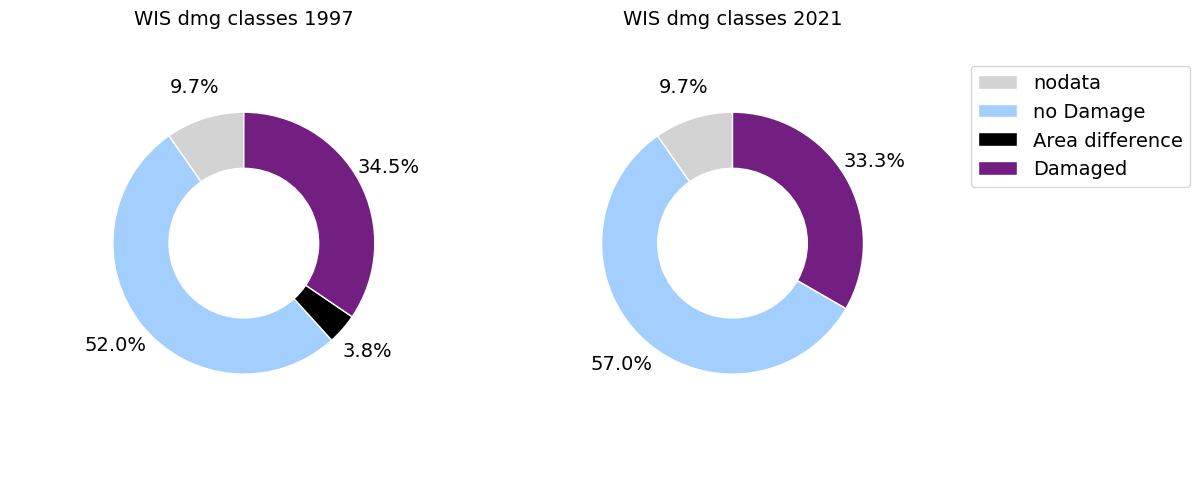

In [14]:
import matplotlib.patches as mpatches
plt.rcParams['hatch.linewidth'] = 1 # 0.5  # previous pdf hatch linewidth


color_noDMG = '#a2cffe' # baby blue
color_DMG = '#721f81' # dmg purple

def my_autopct(pct):
    return ('%.1f%%' % pct) if pct >0.5  else ''


fig, axs = plt.subplots(1,2,figsize=(12,9))
for y, year in enumerate( [1997, 2021] ):

    
    pie_cols_class = ['#nodata','#noDMG', 'Npx_padd','#lowDMG','#mediumDMG','#highDMG']
    pie_colors1 = ['None','None'] + ['None'] + magma_palette_r[1:-2] 
    pie_cols_binary   = ['#nodata','#noDMG', 'Npx_padd' ,'#DMG']; 
    pie_colors2 = [ 'lightgray', color_noDMG, 'black', color_DMG ]
    
    # get single row entry per sector
    df_pieplot = df_sectors_sum_1000.loc[df_sectors_sum_1000['time']==year ] # .groupby(['sector_ID','time']).sum().reset_index()


    # loop sectors
    r=0;c= y;
    for r, idx in enumerate(df_pieplot.index[-2:-1]):
        
        ### Inner & OUTER pie
        size = 0.3 # 0.3
        # fig, axs = plt.subplots(1,figsize=(5,5))
        ax=axs#[r]#[r,c]
        ax=axs[c]#[r,c]

        ''' PIE : binary dmg '''

        # patches2, texts2, _ = ax.pie(df_pieplot.loc[idx, pie_cols_binary], radius=1-size, ## BINARY; INNER
        patches2, texts2, _ = ax.pie(df_pieplot.loc[idx, pie_cols_binary], radius=1-size, ## BINARY; INNER
                colors=pie_colors2, 
                autopct=my_autopct, pctdistance=1.25,#0.3,  #'%1.1f%%',
                textprops={'fontsize': 14},
                wedgeprops=dict(width=size, edgecolor='w'),
                startangle=90,
                )


        ## title stuff
        ax.set_title(df_pieplot.loc[idx,'sector_ID'] + ' dmg classes ' + str(year), y=0.95) # y=0.85)

        # fig.tight_layout()


        '''## create and add legend '''
        # sort_legend = False
        # patches = patches2 + patches[2:] 
        # list_labels = pie_cols_binary + pie_cols_class[2:] #+ [1997, 2021]
        # if c==1:
        #     ax.legend(patches, list_labels, bbox_to_anchor=(1.3,0.9))

        patches = patches2 
        list_labels = ['nodata','no Damage', 'Area difference','Damaged'] # pie_cols_binary  
        if c==1:
            ax.legend(patches2, list_labels, bbox_to_anchor=(1.5,0.9)) # (1.45,0.9))

                    
fig.tight_layout()





##  Piechart  annual dmg, 1000m, binary

ASE 2000
BSE 2000
EIS 2000
RS 2000
WIS 2000
WS 2000


,sector_ID,time,nodata%,noDMG%,DMG%
1,ASE,2000,3,52,46
4,BSE,2000,0,78,22
7,EIS,2000,1,48,51
10,RS,2000,66,22,12
13,WIS,2000,10,49,41
16,WS,2000,35,45,20


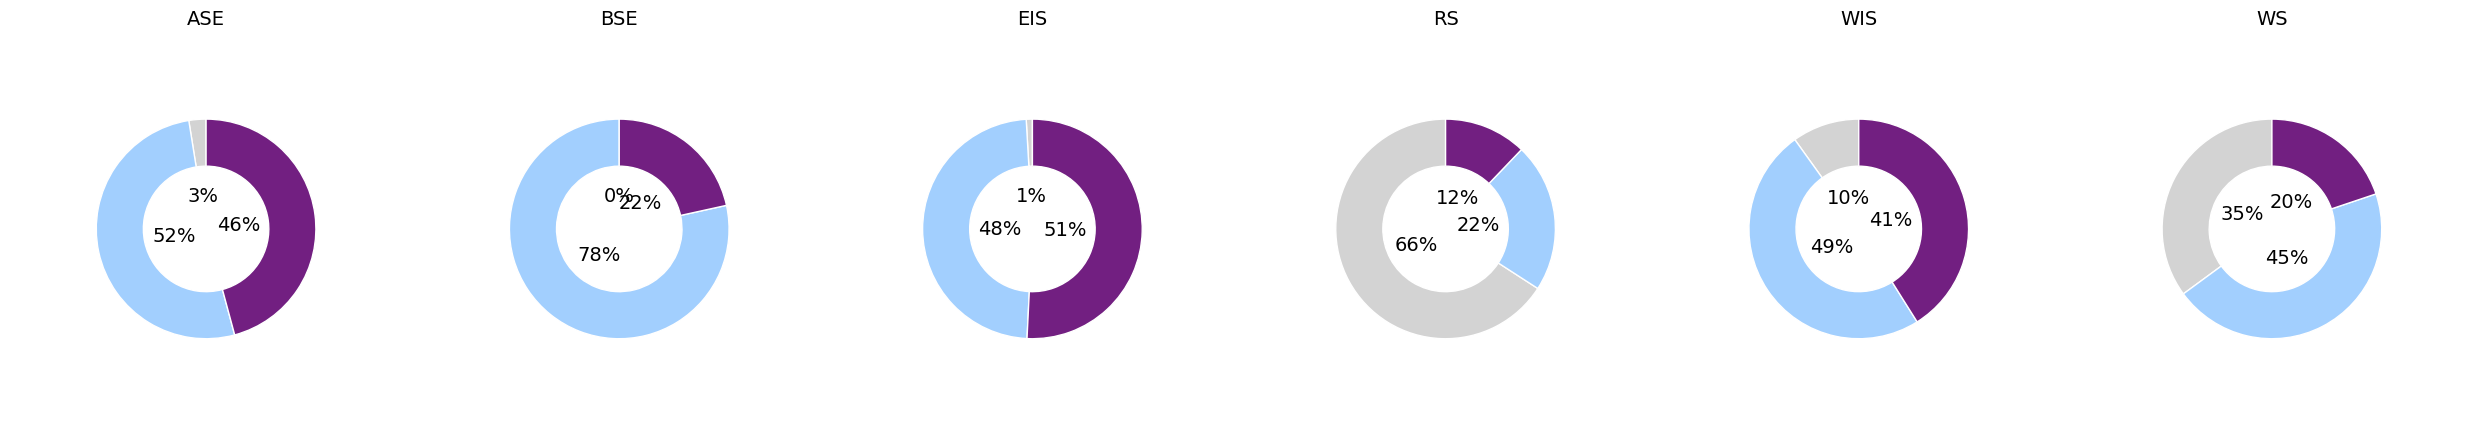

In [15]:
import matplotlib.patches as mpatches

color_noDMG = '#a2cffe'
color_DMG = '#721f81'


def my_autopct(pct):
    return ('%.1f%%' % pct) if pct >0.5  else ''

df_sectors_sum = df_data_1000.groupby(['sector_ID','time']).sum().reset_index()


def my_autopct(pct):
    # return ('%.0f' % pct) if pct < 35 and pct > 0 else ''
    return ('%.1f' % pct) if np.floor(pct) > 0 else ''

fig, axs = plt.subplots(1,6,figsize=(25,5))
# for year in [1997,2015,2016,2017,2018,2019,2020, 2021]:
for year in [2000]:


    pie_cols1 = ['#nodata','#noDMG','#lowDMG','#mediumDMG','#highDMG']#,'#vHighDMG']
    pie_cols2 = ['#nodata','#noDMG','#DMG']; pie_colors2 = ['lightgray', color_noDMG, color_DMG ]

    df_sectors_sum
    df_pieplot = df_sectors_sum.loc[df_sectors_sum['time']==year]

    # to store values:
    df_pct_annual = df_pieplot[['sector_ID','time','#nodata','#noDMG','#DMG']].copy()
    df_pct_annual = df_pct_annual.astype({"#nodata": np.float16, "#noDMG": np.float16, "#DMG": np.float16})

    # r=0;c=0;
    r=0;c=y;
    for r, idx in enumerate(df_pieplot.index):
        sector_name = df_pieplot.loc[idx,'sector_ID']

        print(sector_name, year)

        ## store percentage values in a dataframe
        df_pct_year_sector = (df_pieplot.loc[idx, pie_cols2] / df_pieplot.loc[idx, pie_cols2].sum() ) * 100
        df_pct_annual.loc[idx, ['#nodata','#noDMG','#DMG']] = df_pct_year_sector

        ### Inner & OUTER pie
        size = 0.3
        ax=axs[r]#[r,c]

        ''' INNER PIE : binary dmg '''

        patches2, texts2 = ax.pie(df_pieplot.loc[idx, pie_cols2], radius=1-size, ## BINARY; INNER
                colors=pie_colors2, 
                labels=None, # autopct='%1.0f%%',pctdistance=0.3, 
                wedgeprops=dict(width=size, edgecolor='w'),
                startangle=90,
                )

        # pie with texts
        patches2, texts2, autotxt = ax.pie(df_pieplot.loc[idx, pie_cols2], radius=1-size, ## BINARY; INNER
                colors=pie_colors2, 
                labels=None, # autopct='%1.0f%%',pctdistance=0.3, 
                autopct='%1.0f%%',pctdistance=0.3, 
                wedgeprops=dict(width=size, edgecolor='w'),
                startangle=90,
                )
        ax.set_title(sector_name)

        ## update colors within wedges: no edges for pies
        [patch.set(edgecolor=None) for patch in patches] # outer
            
    # Rename columns starting with '#'
    df_pct_annual.rename(columns={col: f'{col[1:]}%' for col in df_pct_annual.columns if col.startswith('#')}, inplace=True)
    

    pd.options.display.float_format = "{:,.0f}".format
    display(df_pct_annual)

fig.tight_layout()


# hihgh-res piechart for annual dmg: discrete classes

In [17]:

''' ----
Load high res (400m) aggregated data 
---'''
# years_all = np.concatenate([np.array([1997]), np.arange(2015,2022)])
years_hr = np.arange(2015,2022)
df_data=pd.DataFrame()
for year in years_hr:
    print("Loading {}".format(year))
    sector_df_list =[]
    iceshelves_df_list=[]

    df_year_AIS_file = 'aggregated_dmg_per_iceshelf_AIS_' + str(year) + '.shp'
    subdir = '_aggregated_with_nodataMask_annual/'  # Masked S1 annually, but cant distinguish annual gap from None-coverage gap
    path2agg = os.path.join(path2data, subdir)
    
    df_year_AIS = gpd.read_file(os.path.join(path2agg,df_year_AIS_file))

    df_year_AIS['ratio']= (df_year_AIS['#DMG']/df_year_AIS['Npx']*100).round(1)

    ## intersect iceshelf gpd with sector for SNS grouping
    df_year_AIS = gpd.sjoin(df_year_AIS, sector_df, how='right').drop(['Regions'],axis=1)

    ## Combine WIS-a and WIS-b : replace values
    df_year_AIS = df_year_AIS[df_year_AIS['sector_ID'] != 'WIS'] # .drop(['D0_avg','Davg','x_label','y_label'],axis=1)
    df_year_AIS['sector_ID'] = df_year_AIS['sector_ID'].replace(['WIS-a', 'WIS-b'], 'WIS')
    # df_year_AIS = df_year_AIS.groupby('sector_ID').sum().reset_index()

    df_year_AIS['time']=year # set time
    
    df_data = pd.concat([df_data, df_year_AIS])

df_data
    

Processing 2015
Processing 2016
Processing 2017
Processing 2018
Processing 2019
Processing 2020
Processing 2021


,index_left,NAME,D0_avg,Davg,Dsum,Npx,#DMG,#noDMG,#nodata,#lowDMG,#mediumDMG,#highDMG,#vHighDMG,ratio,sector_ID,sectorNAME,x_label,y_label,geometry,time
2,48,Tracy_Tremenchus,0,0,143,16168,6139,10029,0,2998,2564,568,9,38,EIS,East Indian,"2,500,700","-1,700,600","POLYGON ((2742417.175 -38120.436, 2838893.457 ...",2015
2,49,Shackleton,0,0,"1,224",177128,55328,121800,0,28098,22860,4117,252,31,EIS,East Indian,"2,500,700","-1,700,600","POLYGON ((2742417.175 -38120.436, 2838893.457 ...",2015
2,50,Conger_Glenzer,0,0,140,8969,4773,4196,0,1688,2532,520,33,53,EIS,East Indian,"2,500,700","-1,700,600","POLYGON ((2742417.175 -38120.436, 2838893.457 ...",2015
2,51,Underwood,0,0,8,1147,444,703,0,230,193,20,1,39,EIS,East Indian,"2,500,700","-1,700,600","POLYGON ((2742417.175 -38120.436, 2838893.457 ...",2015
2,52,Vincennes_Bay,0,0,73,5993,2338,3655,0,901,1117,286,34,39,EIS,East Indian,"2,500,700","-1,700,600","POLYGON ((2742417.175 -38120.436, 2838893.457 ...",2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13,154,Dalk,-999,NaN,0,264,0,0,264,0,0,0,0,0,WIS,None,NaN,NaN,"POLYGON ((1645238.677 974426.374, 2421867.283 ...",2021
13,155,Flatnes,-999,NaN,0,381,0,0,381,0,0,0,0,0,WIS,None,NaN,NaN,"POLYGON ((1645238.677 974426.374, 2421867.283 ...",2021
13,156,Hovde,-999,NaN,0,97,0,0,97,0,0,0,0,0,WIS,None,NaN,NaN,"POLYGON ((1645238.677 974426.374, 2421867.283 ...",2021
13,157,Sorsdal,0,0,1,758,116,642,0,106,10,0,0,15,WIS,None,NaN,NaN,"POLYGON ((1645238.677 974426.374, 2421867.283 ...",2021


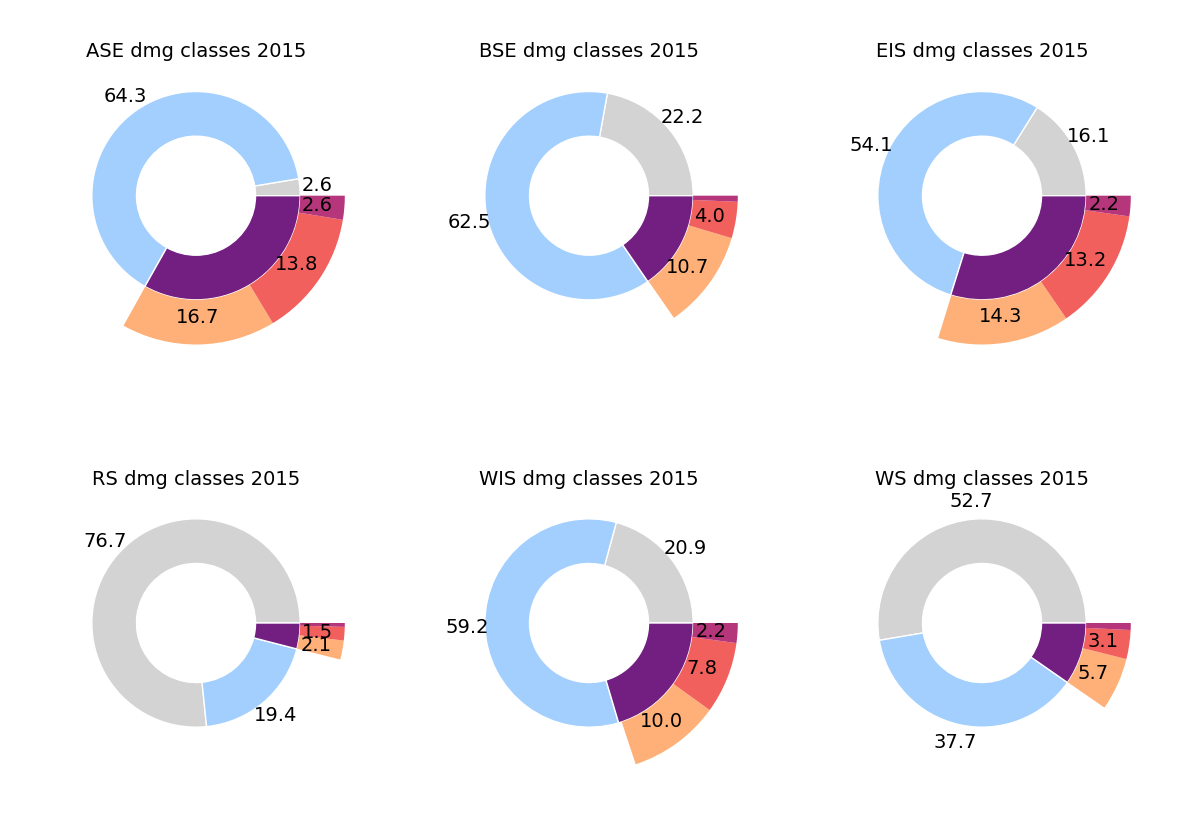

In [26]:
import matplotlib.patches as mpatches
plt.rcParams['hatch.linewidth'] = 1 # 0.5  # previous pdf hatch linewidth

color_noDMG = '#a2cffe'
color_DMG = '#721f81'
# print(fname_suffix)

## Sum data per sector
df_sectors_sum = df_data.groupby(['sector_ID','time']).sum().reset_index()


def my_autopct(pct):
    # return ('%.0f' % pct) if pct < 35 and pct > 0 else ''
    return ('%.1f' % pct) if np.floor(pct) > 0 else ''


# for year in [2015,2016,2017,2018,2019,2020, 2021]:
for year in [2015]:


    pie_cols1 = ['#nodata','#noDMG','#lowDMG','#mediumDMG','#highDMG']#,'#vHighDMG']
    pie_cols2 = ['#nodata','#noDMG','#DMG']; pie_colors2 = ['lightgray', color_noDMG, color_DMG ]

    df_sectors_sum
    df_pieplot = df_sectors_sum.loc[df_sectors_sum['time']==year]
    fig, axs = plt.subplots(2,3,figsize=(12,9))
    fig.subplots_adjust(wspace=0.1)
    
    r=0;c=0;
    # r=0;c=y;
    for i, idx in enumerate(df_pieplot.index):
        sector_name = df_pieplot.loc[idx,'sector_ID']

        # print(sector_name, year)
        # print(r,idx)

        ### Inner & OUTER pie
        size = 0.3
        # fig, axs = plt.subplots(1,figsize=(5,5))
        # fig.set_facecolor('#b7c0c7') # # lighter
        ax=axs[r,c]

        ''' INNER PIE : binary dmg '''

        patches2, texts2 = ax.pie(df_pieplot.loc[idx, pie_cols2], radius=1-size, ## BINARY; INNER
                colors=pie_colors2, 
                labels=None, # autopct='%1.0f%%',pctdistance=0.3, 
                wedgeprops=dict(width=size, edgecolor='w'),
                )

        ''' OUTER PIE : dmg classes '''
        patches, texts, _ = ax.pie(df_pieplot.loc[idx, pie_cols1], radius=1, # -size,  ## CLASSES; OUTER
        # patches, texts = ax.pie(df_pieplot.loc[idx, pie_cols1], radius=1, # -size,  ## CLASSES; OUTER
                colors=['None','None'] + magma_palette_r[1:], #
                autopct=my_autopct, pctdistance=0.82, #  pctdistance=1.3, 
                # labels=None,
                wedgeprops=dict(width=size, edgecolor='w'),
                # hatch=[hatch_year],
                )

        ## update colors within wedges: no edges for pies
        [patch.set(edgecolor=None) for patch in patches] # outer
        # [patch.set(edgecolor=None) for patch in patches2] # inner

        # title stuff
        ax.set_title(df_pieplot.loc[idx,'sector_ID'] + ' dmg classes ' + str(year), y=0.85)
        

        c+=1
        if c>2:
            r+=1
            c=0                
        # fig.tight_layout()

        # SAVE FIGURE
        # fname = 'piechart_dmg_clean_'+sector_name+'_'+str(year)+'.pdf'
        # print('saving to ..', fname)
        # fig.savefig(os.path.join(path2savefig,'piechart/_piecharts_clean_annual',fname), bbox_inches='tight', format='pdf')
fig.tight_layout()
